## Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/temp.csv',index_col=0)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-01-13 11:28:00.00000062,14.9,2012-01-13 11:28:00 UTC,-73.955268,40.782767,-73.932382,40.794812,6
1,2014-06-30 11:26:37.0000001,6.0,2014-06-30 11:26:37 UTC,-73.995635,40.744387,-74.002325,40.730406,1
2,2012-04-08 13:42:13.0000001,5.3,2012-04-08 13:42:13 UTC,-73.992020,40.731651,-74.003277,40.731583,1
3,2009-08-18 11:18:00.000000117,6.9,2009-08-18 11:18:00 UTC,-73.993190,40.744670,-73.978242,40.752835,1
4,2013-04-30 08:00:00.000000137,7.5,2013-04-30 08:00:00 UTC,-73.992223,40.748710,-73.998547,40.758332,1


In [ ]:
#dropping null rows
df=df.dropna()

In [ ]:
#dropping rows where the fare is below 0 and above 200 considering it as outlier, however only one row is present
df = df.drop(df[df['fare_amount'] < 0].index)
df = df.drop(df[df['fare_amount'] >200].index)

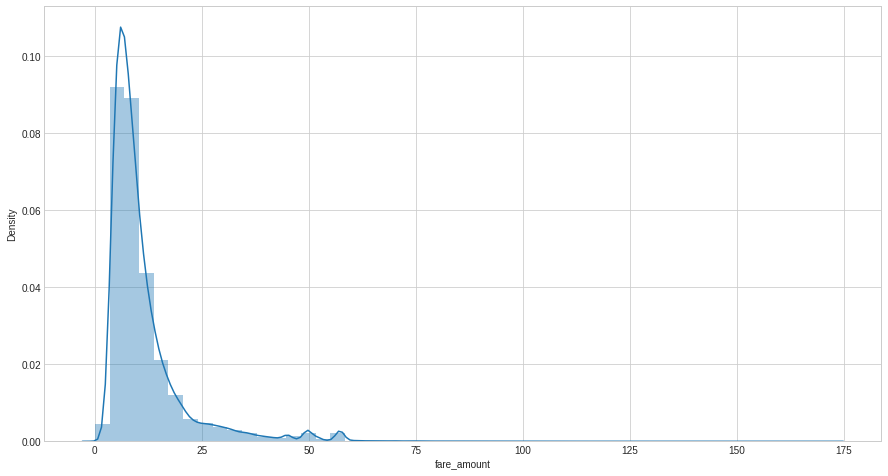

In [ ]:
#distribution of fare amount
plt.figure(figsize=(15, 8))
sns.distplot(df['fare_amount'])

Text(0, 0.5, 'Frequency')

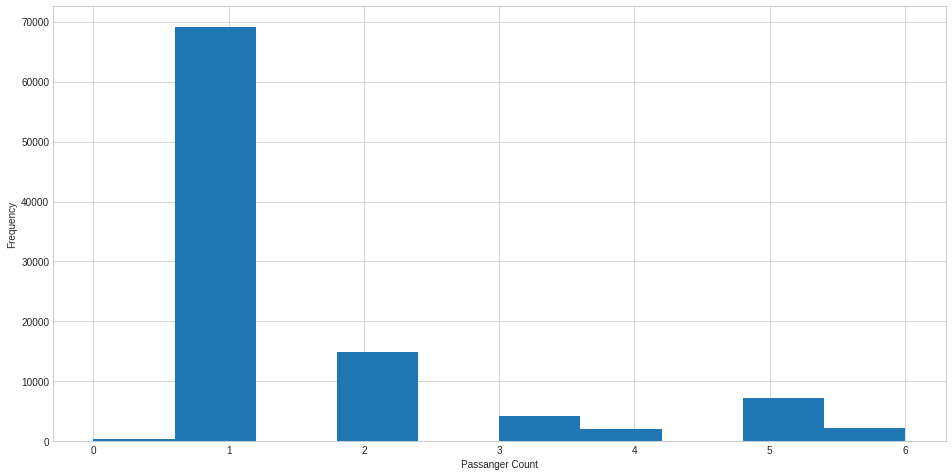

In [ ]:
#distribution of rows with passengercount
df.passenger_count.hist(bins=10, figsize = (16,8))
plt.xlabel("Passanger Count")
plt.ylabel("Frequency")

In [ ]:
#Rows with passenger 0 or below which are senseless
df[df.passenger_count ==0].shape

(333, 8)

In [ ]:
df=df.drop(df[df['passenger_count'] ==0].index)

Text(0, 0.5, 'Frequency')

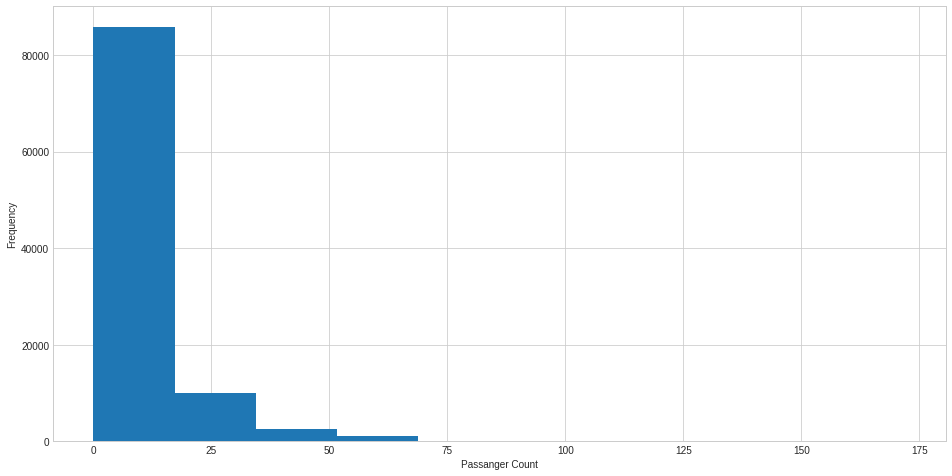

In [ ]:
#distribution of rows with fare amount 
df.fare_amount.hist(bins=10, figsize = (16,8))
plt.xlabel("Passanger Count")
plt.ylabel("Frequency")

In [ ]:
#Rows with fare amount 0 
df[df.fare_amount ==0].shape

(3, 8)

In [ ]:
df=df.drop(df[df['fare_amount'] ==0].index)

## Feature engineering

In [ ]:
#calculate distance covered in trip
from math import sin, cos, sqrt, atan2, radians
def Calculate_distance(lat1,lon1,lat2,lon2):
  # approximate radius of earth in km
  R = 6373.0
  dlon=lon2-lon1
  dlat=lat2-lat1
  a=sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2 
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  d=R*c
  return d 


distances_km=[]
for row in df.itertuples(index=False):
  distances_km.append(Calculate_distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude))
df['trip_distance_km']=distances_km

In [ ]:
#extarct datetime features
def Extract_datetime_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['hour'] = df.pickup_datetime.dt.hour
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df["day"] = df.pickup_datetime.dt.weekday
    return df
df = Extract_datetime_features(df)

In [ ]:
#dropping unnecessary rows
df=df.drop(columns=['key','pickup_datetime'])

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df.drop('fare_amount', axis=1),
                                                    df['fare_amount'], test_size=0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79726, 10)
(19932, 10)
(79726,)
(19932,)


## Model

In [ ]:
import xgboost as xgb
params = {
   
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(X_train,X_test,y_train,y_test,params)

[01:01:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:14.2695
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:13.8916
[2]	test-rmse:13.5256
[3]	test-rmse:13.1724
[4]	test-rmse:12.8307
[5]	test-rmse:12.5009
[6]	test-rmse:12.1817
[7]	test-rmse:11.8727
[8]	test-rmse:11.5729
[9]	test-rmse:11.2878
[10]	test-rmse:11.0099
[11]	test-rmse:10.7412
[12]	test-rmse:10.4808
[13]	test-rmse:10.2308
[14]	test-rmse:10.0092
[15]	test-rmse:9.77599
[16]	test-rmse:9.55088
[17]	test-rmse:9.33526
[18]	test-rmse:9.12665
[19]	test-rmse:8.9261
[20]	test-rmse:8.73584
[21]	test-rmse:8.54895
[22]	test-rmse:8.37237
[23]	test-rmse:8.20192
[24]	test-rmse:8.03449
[25]	test-rmse:7.87746
[26]	test-rmse:7.72438
[27]	test-rmse:7.5802
[28]	test-rmse:7.4398
[29]	test-rmse:7.30468
[30]	test-rmse:7.17616
[31]	test-rmse:7.0514
[32]	test-rmse:6.93479
[33]	test-rmse:6.82005
[34]	test-rmse:6.71407
[35]	test-rmse:6.60959
[3